# Locating Cryptographic Code

## Setup

Initial setup, such as importing required libraries, starting the database container, etc.

In [ ]:
# Automatically reload modules.
%load_ext autoreload
%autoreload 2

# Add project root to Python search path.
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Python imports.
import subprocess
import shutil
import math
import hashlib
import time

# Plotting.
import matplotlib.pyplot as plt
%matplotlib inline

# Data analysis.
import numpy as np
import pandas as pd
import seaborn as sns

# Import MATE framework.
from core.core import Core
from core.workspace import Workspace

# Import demos of MATE framework.
from demos.curl.demo import demo as run_curl_demo

# Load workspaces from database.
Workspace.load_from_db(Core())

## Utility functions

Several helper functions used throughout the notebook.

In [ ]:
def pretty_print_instruction(ins):
    print(f"{ins['image_name']}:{hex(ins['image_offset'])}: {ins['mnem']} {ins['operands']}")

## Benchmarks

This section contains a list of possible benchmarks, and the code needed to run them and import the results in the database.

### List of possible benchmarks

- Applications based on `libcrypto`:
    - `curl`
    - `openssl`
    - `wget`
- `keepassxc`
- Applications based on `libgcrypt`:
    - `gpg`
    - `pass`
- `lynx` (uses `libgnutls`)
- `7z`: useful to check if entropy metric also detects compression
- `VeraCrypt`
- packer/unpacker
- VLC

### Running the benchmarks

#### curl

`curl` is a command-line application used to download data from URLs.
It uses `libcrypto` for some of its cryptographic operations.
As a benchmark, we use the following `curl` call:
```bash
/usr/bin/curl https://tools.ietf.org/rfc/rfc5246.txt -o rfc5246.txt
```

In [ ]:
%time run_curl_demo()

## Techniques examples

### Values used in encrypted/decrypted data

If we know (part of) the encrypted or decrypted data, we can simply look for instructions that read or write a byte sequence that occurs in that data.

**NOTE:** This broke when we switched from a pre-built `curl` to a build from source, probably because of different compiler options.

#### curl

In [ ]:
Workspace.select('curl')

Let's look at the first couple bytes that are transferred over the network, by checking the output of `curl`.

In [ ]:
! curl https://tools.ietf.org/rfc/rfc5246.txt -o - 2>/dev/null | hexdump -C | head -5

The first 16 bytes of the result are `0a 0a 0a 0a 0a 0a 4e 65 74 77 6f 72 6b 20 57 6f`. Let's look for instructions that write these 16 bytes:

In [ ]:
def find_instructions():
    # Get reference to database.
    db = Workspace.current.graph
    
    # Find instructions that write the first 16 bytes of the expected result.
    first_bytes = '0a 0a 0a 0a 0a 0a 4e 65 74 77 6f 72 6b 20 57 6f'
    query = f'''
             MATCH (ins:Instruction)
             WHERE ins.written_values CONTAINS "{first_bytes}"
             RETURN (ins)
             '''
    return db.run_list(query)

instructions = find_instructions()
print(f'Found {len(instructions)} candidate instruction(s).')

It looks like we uniquely identified the instruction that writes the output. Let's print the address, so we can check in Binary Ninja.

In [ ]:
# TODO: Uncomment this
#assert(len(instructions) == 1)
#pretty_print_instruction(instructions[0]['ins'])

Open `libcrypto.so.1.1` in Binary Ninja, and go to the address `0x18fdae` using the <kbd>G</kbd> key.

In the same function as the `vmovups xmmword ptr [rsi-0x60], xmm9`, you will find `vaesenclast` instructions, that perform the last round of the AES encryption flow.

Using this simple technique, we successfully identified the cryptographic code used by `curl`.

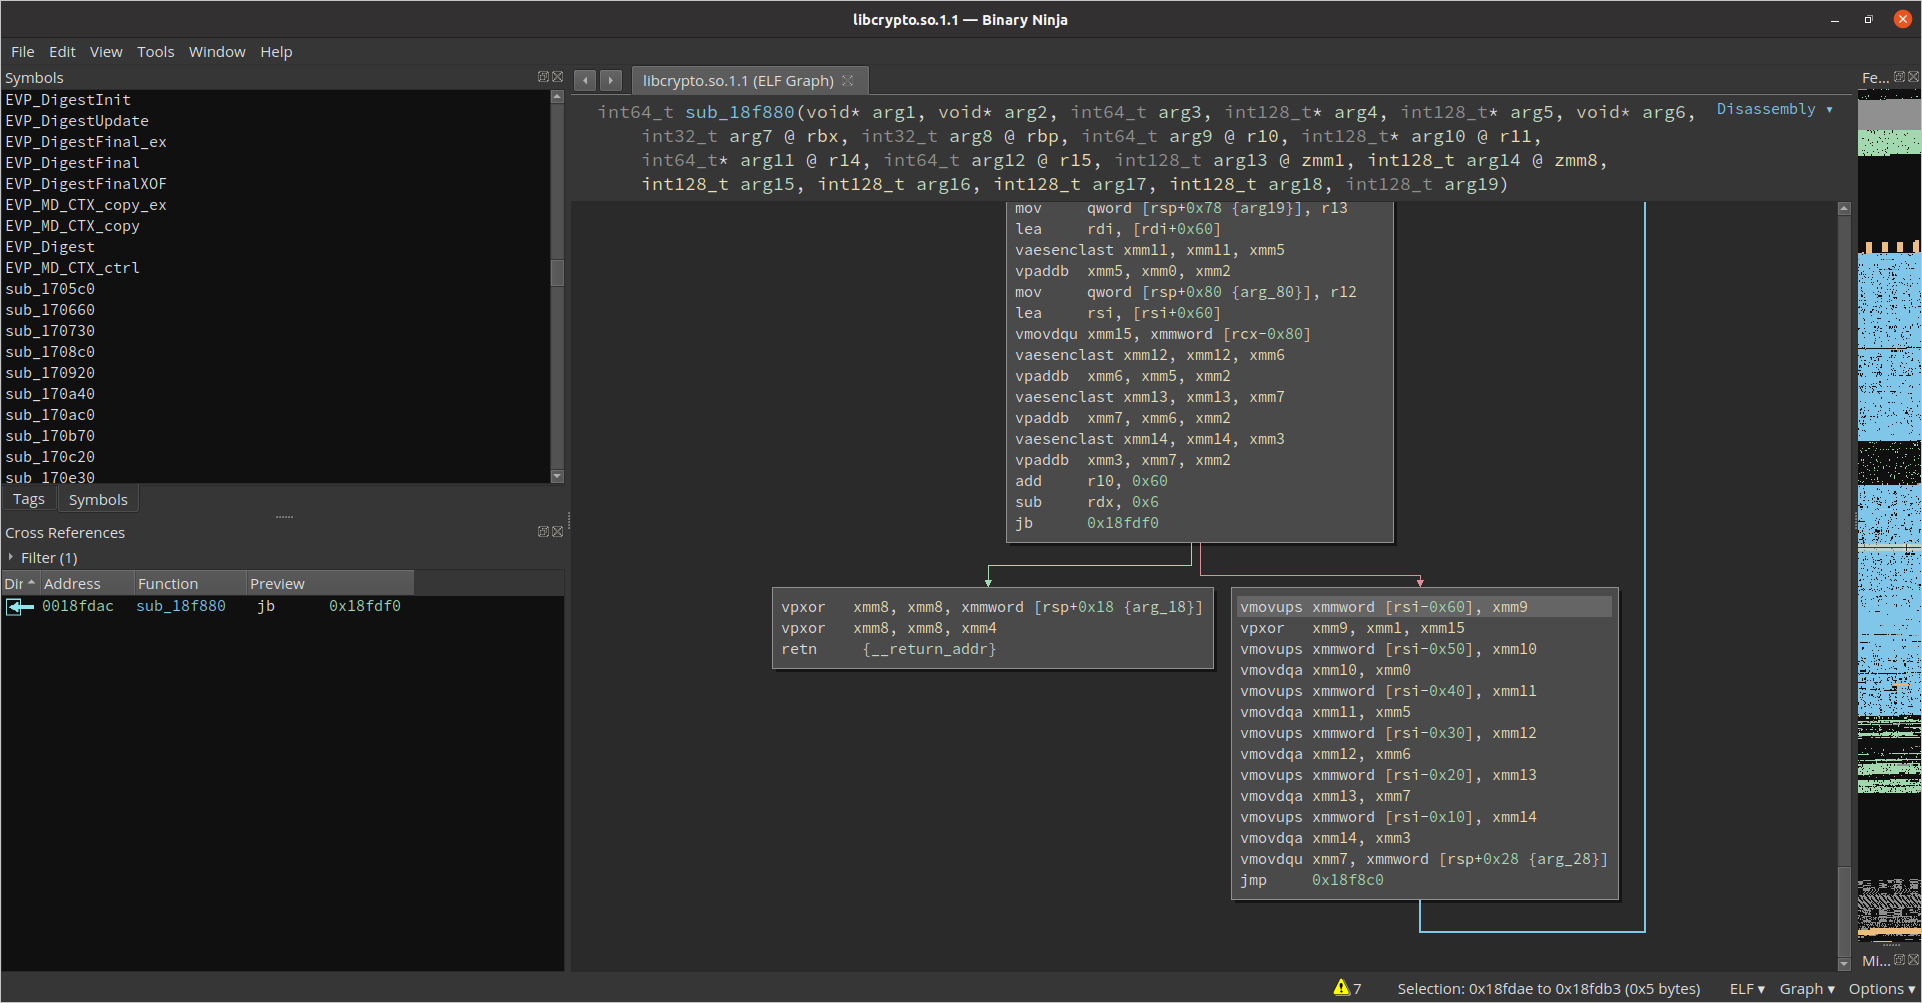

Of course, we got lucky because `libcrypto` uses a 16-byte vectorised store (`vmovups`).

Let's see how the number of results varies with different prefix lengths:

In [ ]:
def num_instructions_for_prefix(prefix_length):
    # Get reference to database.
    db = Workspace.current.graph
    
    # First 16 bytes of result
    first_bytes = ['0a', '0a', '0a', '0a', '0a', '0a', '4e', '65', '74', '77', '6f', '72', '6b', '20', '57', '6f']
    
    assert(prefix_length >= 1)
    assert(prefix_length <= len(first_bytes))
    
    bytes_query = ' '.join(first_bytes[1:prefix_length])
    
    query = f'''
             MATCH (ins:Instruction)
             WHERE ins.written_values CONTAINS "{bytes_query}"
             RETURN (ins)
             '''
    return len(db.run_list(query))

x = range(1, 16)
y = [num_instructions_for_prefix(i) for i in x]

for x_el, y_el in zip(x, y):
    print(f'{x_el:2} byte(s): {y_el} result(s)')
print()

plt.title('Influence of prefix length on number of results')
plt.xlabel('Prefix length [number of bytes]')
plt.ylabel('Number of results')
plt.semilogy(x, y);

### Entropy of memory regions/buffers

In this technique, we will locate cryptographic buffers by calculating the entropy of the memory buffers and memory regions used by the application, and investigating memory locations of high entropy.

#### curl

In [ ]:
Workspace.select('curl')

Let's plot the distribution of the spatial entropy of buffers for `curl`.

In [ ]:
def plot_spatial_entropy_distribution(metrics, nrows = 1, ncols = 1, node_types = ['MemoryBuffer']):
    # Get reference to database.
    db = Workspace.current.graph
    
    data = {}
    
    for metric in metrics:
        # Get the spatial entropies of all buffers.
        node_type_query = ' OR '.join([f'buf:{node_type}' for node_type in node_types])
        query = f'''
                 MATCH (buf)
                 WHERE ({node_type_query}) AND EXISTS (buf.average_spatial_entropy_{metric})
                 RETURN (buf)
                 ORDER BY buf.average_spatial_entropy_{metric}
                 '''
    
        buffers_with_entropies = db.run_list(query)
        spatial_entropies = np.array([entry['buf'][f'average_spatial_entropy_{metric}'] for entry in buffers_with_entropies])

        print(f'Got {len(spatial_entropies)} nodes of type(s) {", ".join(node_types)} with spatial entropy {metric}.')
        print()

        print(f'Mean:          {np.mean(spatial_entropies)}')
        print(f'Quartile Q0:   {np.quantile(spatial_entropies, 0.00)}')
        print(f'Quartile Q1:   {np.quantile(spatial_entropies, 0.25)}')
        print(f'Quartile Q2:   {np.quantile(spatial_entropies, 0.50)}')
        print(f'Quartile Q3:   {np.quantile(spatial_entropies, 0.75)}')
        print(f'Quartile Q4:   {np.quantile(spatial_entropies, 1.00)}')
        print()
        
        data[metric] = spatial_entropies

    plt.figure(figsize = (nrows*6.4, ncols*4.8))
    plt.suptitle(f'Distribution of spatial entropies ({", ".join(node_types)})', fontsize=16)
        
    ax = None
    
    for i, metric in enumerate(metrics):
        if ax is None:
            ax = plt.subplot(nrows, ncols, i+1)
        else:
            plt.subplot(nrows, ncols, i+1, sharey = ax)
        plt.title(f'{metric}')
        plt.xlabel('Spatial entropy')
        plt.ylabel('Absolute frequency')
        plt.hist(data[metric], bins=10)
        
    plt.tight_layout()
    
plot_spatial_entropy_distribution(['bit_shannon'])

We are using Shannon entropy with alphabet $\mathbb{Z}_2 = \{ 0, 1 \}$, i.e. $H(X) = - p_0 log_2(p_0) - p_1 log_2(p_1)$, where $p_i$ is the number of times the bit $i$ occurs.

But techniques in the literature / tools calculate entropy at the byte level, e.g. radare2, binwalk, Matenaar2012, Lutz2008, ent(1).

Using $\mathbb{Z}_{256}$ instead of $\mathbb{Z}_2$, i.e. calculating the entropy at a **byte** instead of a **bit** level, should provide a more accurate view on entropy.

Normally, one would define the (scaled) Shannon entropy at a byte level as:
$$
H(X) = \frac{- \sum_{i=0}^{255} p_i \log_2(p_i)}{\log_2(256)}
$$
where $p_i$ is the fraction of occurences of the byte value $i$.

But for buffers of length $N < 256$, the entropy $H(X)$ is bounded by the the size of the buffer, not the size of the alphabet.

In that case, $H(X) \leq \log_2(N)$.

Therefore, it is better to define the scaled entropy as follows:
$$
H(X) = \frac{- \sum_{i=0}^{255} p_i \log_2(p_i)}{\log_2(\min(N, 256))}
$$
This is the approach taken by radare2, Matenaar2012, Lutz2008.

Other possible metrics for entropy are:

- Counting how many _different_ bytes occur: e.g. $\{1, 1, 2, 3, 3\} \to 3$
- Counting how many _unique_ bytes occur: e.g. $\{1, 1, 2, 3, 3\} \to 1$

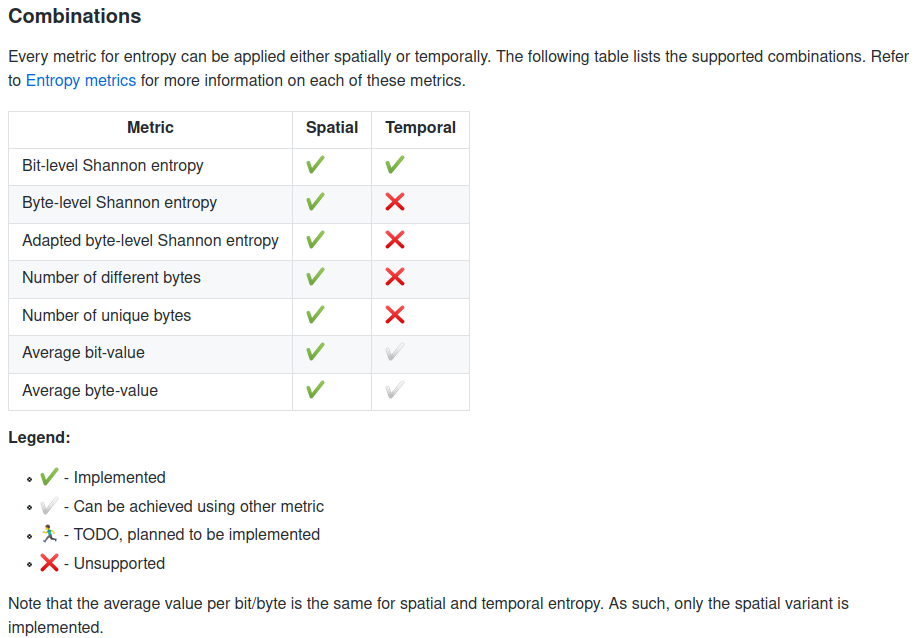

Let us plot the distribution for these other metrics:

In [ ]:
metrics = ['bit_shannon', 'byte_shannon', 'byte_shannon_adapted', 'byte_num_different', 'byte_num_unique', 'bit_average', 'byte_average']
plot_spatial_entropy_distribution(metrics, 3, 3)

In [ ]:
metrics = ['bit_shannon', 'byte_shannon', 'byte_shannon_adapted', 'byte_num_different', 'byte_num_unique', 'bit_average', 'byte_average']
plot_spatial_entropy_distribution(metrics, 3, 3, node_types = ['MemoryRegion'])

Let us see how the different metrics are correlated:

In [ ]:
def plot_spatial_entropy_correlation(metrics, node_types = ['MemoryBuffer', 'MemoryRegion'], transform_entropies = False, scale_squares = False):
    # Get reference to database.
    db = Workspace.current.graph
    
    node_type_query = ' OR '.join([f'buf:{node_type}' for node_type in node_types])
    node_entropy_query = ' AND '.join([f'EXISTS (buf.average_spatial_entropy_{metric})' for metric in metrics])
    return_query = ', '.join([f'buf.average_spatial_entropy_{metric}' for metric in metrics])
    query = f'''
             MATCH (buf)
             WHERE ({node_type_query}) AND ({node_entropy_query})
             RETURN {return_query}
             '''
    
    df = db.run_to_df(query)

    print(f'Got {len(df)} entries with all of the given spatial entropies.')
    print()
    
    # Transform the bit_average and byte_average so that increasing values correspond to increasing entropy
    if transform_entropies:
        df['buf.average_spatial_entropy_bit_average'] = df['buf.average_spatial_entropy_bit_average'].map(lambda x: 0.5 - abs(0.5 - x))
        df['buf.average_spatial_entropy_byte_average'] = df['buf.average_spatial_entropy_byte_average'].map(lambda x: 128 - abs(128 - x))
    
    plt.figure(figsize = (2*6.4, 2*4.8))
    plt.suptitle(f'Correlation between spatial entropy metrics ({", ".join(node_types)})', fontsize=16)
    
    if not scale_squares:
        # using seaborn
        ax = sns.heatmap(df.corr(), vmin = -1, center = 0, vmax = 1, xticklabels = metrics, yticklabels = metrics, square = True, cmap = sns.diverging_palette(20, 220, n = 200))
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
    else:
        # using heatmapz
        import heatmap
        heatmap.corrplot(df.corr(), size_scale = 2500)
    
metrics = ['bit_shannon', 'byte_shannon', 'byte_shannon_adapted', 'byte_num_different', 'byte_num_unique', 'bit_average', 'byte_average']
plot_spatial_entropy_correlation(metrics, transform_entropies = False, scale_squares = True)

##### Evaluation
Let's annotate buffers manually with whether or not they are crypto for evaluation purposes.

In [ ]:
def print_annotation_stats():
    db = Workspace.current.graph
    
    query = '''
            MATCH (buf:MemoryBuffer)
            RETURN DISTINCT (buf.DEBUG_annotation) AS annotation, COUNT(DISTINCT buf) AS count
            '''
    
    data = db.run_list(query)
    
    num_crypto_both = 0
    num_crypto_true = 0
    num_crypto_false = 0
    num_unannotated = 0
    
    for entry in data:
        annotation = entry['annotation']
        count = entry['count']
        
        if ('crypto:true' in annotation) and ('crypto:false' in annotation):
            num_crypto_both += count
        elif ('crypto:true' in annotation):
            num_crypto_true += count
        elif ('crypto:false' in annotation):
            num_crypto_false += count
        else:
            num_unannotated += count
    
    total = num_crypto_both + num_crypto_true + num_crypto_false + num_unannotated
        
    print(f'Statistics for crypto annotation')
    print(f'================================')
    print()
    
    print(f'crypto:true AND crypto:false:    {num_crypto_both:10} ({100 * num_crypto_both / total:.3f}%)')
    print(f'crypto:true:                     {num_crypto_true:10} ({100 * num_crypto_true / total:.3f}%)')
    print(f'crypto:false:                    {num_crypto_false:10} ({100 * num_crypto_false / total:.3f}%)')
    print(f'no annotation:                   {num_unannotated:10} ({100 * num_unannotated / total:.3f}%)')
    
print_annotation_stats()

In [ ]:
def print_annotated_buffers():
    db = Workspace.current.graph
    
    data = db.run_list('''
                   MATCH (buf:MemoryBuffer)
                   WHERE size(buf.DEBUG_annotation) > 0
                   RETURN (buf.DEBUG_annotation) AS annotation,
                          (buf.average_spatial_entropy_byte_shannon_adapted) AS entropy,
                          (buf.end_address - buf.start_address) AS size,
                          (buf.num_writes) AS num_writes,
                          (buf.DEBUG_allocation_backtrace) AS backtrace
                   ORDER BY backtrace
           ''')
    
    print(f'Found {len(data)} annotated buffers.')
    print()
    
    for entry in data:
        bt = entry['backtrace'].translate({ord('|'): '\n'})
        bt_hash = hashlib.sha256(entry['backtrace'].encode()).hexdigest()
        
        print(f"ID:              {bt_hash}")
        print(f"Annotations:     {entry['annotation']}")
        print(f"Entropy:         {entry['entropy']}")
        print(f"Size:            {entry['size']} bytes")
        print(f"#Writes:         {entry['num_writes']} write(s)")
        print(f"Backtrace:\n{bt}")
        print()

print_annotated_buffers()

In [ ]:
def print_buffers_ordered_by_entropy(amount, order):
    db = Workspace.current.graph
    
    data = db.run_list(f'''
                   MATCH (buf:MemoryBuffer)
                   WHERE EXISTS (buf.average_spatial_entropy_byte_shannon_adapted)
                   RETURN (buf.DEBUG_annotation) AS annotation,
                          (buf.average_spatial_entropy_byte_shannon_adapted) AS entropy,
                          (buf.end_address - buf.start_address) AS size,
                          (buf.num_writes) AS num_writes,
                          (buf.DEBUG_allocation_backtrace) AS backtrace
                   ORDER BY (buf.average_spatial_entropy_byte_shannon_adapted) {order}
                   LIMIT {amount}
                   ''')
    
    print(f'TOP {amount} BUFFERS SORTED USING {order} ENTROPY')
    print(f'---------------------------------------------------')
    print()
    
    for entry in data:
        bt_hash = hashlib.sha256(entry['backtrace'].encode()).hexdigest()
        bt = entry['backtrace'].translate({ord('|'): '\n'})
        
        print(f"ID:              {bt_hash}")
        print(f"Annotations:     {entry['annotation']}")
        print(f"Entropy:         {entry['entropy']}")
        print(f"Size:            {entry['size']} bytes")
        print(f"#Writes:         {entry['num_writes']} write(s)")
        print(f"Backtrace:\n{bt}")
        print()

for order in ['DESCENDING', 'ASCENDING']:
    print_buffers_ordered_by_entropy(5, order)

### Entropy of read/written values

Let's check the entropy of read or written values of instructions, and try to detect crypto based on instructions that write high entropy values.

In [ ]:
Workspace.select('curl')

In [ ]:
def get_instructions_entropies():
    db = Workspace.current.graph
    
    data = db.run_list('''
        MATCH (ins:Instruction)
        WHERE EXISTS (ins.read_values_entropy) AND EXISTS (ins.written_values_entropy)
        RETURN (ins)
        ORDER BY ins.written_values_entropy DESCENDING
    ''')
    
    return data

data = get_instructions_entropies()

print(f'Got {len(data)} result(s).')

In [ ]:
plt.suptitle('Distribution of entropy of written values of instructions', fontsize=16)
plt.xlabel('Entropy')
plt.ylabel('Absolute frequency')
plt.yscale('log')
plt.hist(np.array([elem['ins']['written_values_entropy'] for elem in data]));

In [ ]:
def get_high_entropy_instructions(count):
    db = Workspace.current.graph
    
    data = db.run_list(f'''
        MATCH (ins:Instruction)
        WHERE EXISTS (ins.read_values_entropy) AND EXISTS (ins.written_values_entropy)
        RETURN (ins)
        ORDER BY ins.written_values_entropy DESCENDING
        LIMIT {count}
    ''')
    
    return data

high_entr = get_high_entropy_instructions(50)

for elem in high_entr:
    print('{:30}'.format('Instruction:'), end='')
    pretty_print_instruction(elem['ins'])
    print('{:30}{}'.format('Routine:', elem['ins']['routine_name']))
    print('{:30}{}'.format('Entropy of written values:', elem['ins']['written_values_entropy']))
    print('{:30}{}'.format('Number of bytes written:', elem['ins']['num_bytes_written']))
    print()

### Aggregating memory buffers with same allocation site

Experiments with aggregating the statistics of memory buffers that are allocated for the same reason (i.e. at the same location in source code).

We also add the spread in entropy for each aggregated category, to get an idea if we are aggregating too many buffers.

In [ ]:
Workspace.select('curl')

In [ ]:
# Get the number of unique allocation backtraces for a given depth of the backtrace
def get_num_unique_backtraces(depth):
    db = Workspace.current.graph

    all_bts = db.run_list('''
                     MATCH (buf:MemoryBuffer)
                     WHERE EXISTS (buf.DEBUG_allocation_backtrace)
                     RETURN (buf.DEBUG_allocation_backtrace) AS bt, (buf.end_address - buf.start_address) AS size
                     ''')
        
    # Count how many times each backtrace occurs
    bt_counts = {}
    
    for entry in all_bts:
        bt = entry['bt']
        size = entry['size']
        
        bt_split = bt.split('|')
        bt_joined = '\n'.join(bt_split[0:depth])
        
        key = (bt_joined, size)
                
        if key not in bt_counts:
            bt_counts[key] = 0
        
        bt_counts[key] += 1
    
    num_unique = len(bt_counts.values())
    min_count = min(bt_counts.values())
    max_count = max(bt_counts.values())
    total = sum(bt_counts.values())
    
    print(f'Depth = {depth}: #unique backtrace + size combos = {num_unique}, min reuse={min_count}, max reuse={max_count}, total = {total}')

for depth in range(1, 11):
    get_num_unique_backtraces(depth)

In [ ]:
# Example 1: aggregate buffers with the same size
pd.DataFrame(Workspace.current.graph.run('''
MATCH (buf:MemoryBuffer)
WHERE (buf.average_spatial_entropy_byte_shannon IS NOT NULL)
RETURN buf.end_address - buf.start_address AS size,
       count(*) AS buffer_count,
       min(buf.average_spatial_entropy_byte_shannon) AS min_entropy,
       max(buf.average_spatial_entropy_byte_shannon) AS max_entropy,
       max(buf.average_spatial_entropy_byte_shannon) - min(buf.average_spatial_entropy_byte_shannon) AS entropy_range
ORDER BY entropy_range
''').data())

In [ ]:
# Example 2: aggregate buffers with the same size AND same return address in malloc
pd.DataFrame(Workspace.current.graph.run('''
MATCH (buf:MemoryBuffer)
WHERE (buf.average_spatial_entropy_byte_shannon IS NOT NULL)
RETURN buf.end_address - buf.start_address AS size,
       reduce(accumulator = '', i IN range(0, 1) | accumulator + ';' + split(buf.DEBUG_allocation_backtrace, '|')[i]) AS bt,
       count(*) AS buffer_count,
       min(buf.average_spatial_entropy_byte_shannon) AS min_entropy,
       max(buf.average_spatial_entropy_byte_shannon) AS max_entropy,
       max(buf.average_spatial_entropy_byte_shannon) - min(buf.average_spatial_entropy_byte_shannon) AS entropy_range
ORDER BY entropy_range
''').data())

In [ ]:
# Example 3: aggregate buffers that are accessed by a common instruction
pd.set_option('display.max_rows', 2000)
pd.DataFrame(Workspace.current.graph.run('''
MATCH (buf:MemoryBuffer) <-[:WRITES_TO]- (ins:Instruction)
WHERE (buf.average_spatial_entropy_byte_shannon IS NOT NULL)
RETURN ins.image_name,
       ins.image_offset,
       count(*) AS buffer_count,
       min(buf.average_spatial_entropy_byte_shannon) AS min_entropy,
       max(buf.average_spatial_entropy_byte_shannon) AS max_entropy,
       max(buf.average_spatial_entropy_byte_shannon) - min(buf.average_spatial_entropy_byte_shannon) AS entropy_range
ORDER BY entropy_range
''').data())

In [ ]:
# Example 4: aggregate buffers based on allocation address
pd.set_option('display.max_rows', 2000)
pd.DataFrame(Workspace.current.graph.run('''
MATCH (buf:MemoryBuffer)
WHERE (buf.average_spatial_entropy_byte_shannon IS NOT NULL)
RETURN buf.allocation_address,
       count(*) AS buffer_count,
       min(buf.average_spatial_entropy_byte_shannon) AS min_entropy,
       max(buf.average_spatial_entropy_byte_shannon) AS max_entropy,
       max(buf.average_spatial_entropy_byte_shannon) - min(buf.average_spatial_entropy_byte_shannon) AS entropy_range
ORDER BY entropy_range
''').data())